###This notebook demonstrates the use of the SwinV2 Vision Transformer for segmentation on a custom dataset.

MIT License

Copyright (c) 2024 OlgaOlmi (Olga Mindlina)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
!pip install torchinfo

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import copy
import cv2
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
import torchvision.utils

from zipfile import ZipFile

from transformers import AutoImageProcessor, Swinv2Model

# GPU usage settings

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Google drive mounting

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Use of the pre-trained model setting (load an already trained model or start new training) + other common settings

In [7]:
use_pre_trained = True # True - load the model already trained and saved, False - train the model
"""
When save_input_classes = True and save_train_test_splitting = True,
the initial splitting of the data into training and test sets is performed.
"""
save_input_classes = False
save_train_test_splitting = False

In [8]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data/'
CURR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/'

FILE_NAME = CURR_PATH + 'model_seg_pytorch_medical.cnn'   # to save the model check-points during the training
FILE_NAME_PR = DATA_PATH + 'model_segEx_swinV2_medical_21_st.cnn' # the pre-trained model

r_size = 256
batch_size = 16
ep_num = 23

zip_name = 'kaggle_3mN.zip'

#Full list of files with MR images (from zip-file)

In [9]:
with ZipFile(DATA_PATH + zip_name, 'r') as f:
    names = f.namelist()

len(names), names[10]

(15827, 'kaggle_3mN/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11+_mask.tif')

In [10]:
names = [n.split('/')[-1] for n in names]
names = list(filter(lambda x: (x != '' and x != 'data.csv' and x != 'README.md'), names))
names[0], len(names)

('TCGA_CS_4941_19960909_1+.tif', 15716)

In [11]:
f_names = [ 'kaggle_3mN/' + n[:21] + '/' + n for n in names]
f_names[0]

'kaggle_3mN/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1+.tif'

In [12]:
f_images = list(filter(lambda x: 'mask' not in x, f_names))
f_images[0], len(f_images)

('kaggle_3mN/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1+.tif', 7858)

In [13]:
f_masks = list(filter(lambda x: 'mask' in x, f_names))
f_masks[0], len(f_masks)

('kaggle_3mN/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1+_mask.tif', 7858)

In [14]:
del f_names
del f_masks

#Showing a picture and a mask-picture

In [15]:
def show_input_sample(f_images):
    random.shuffle(f_images)
    with ZipFile(DATA_PATH + zip_name) as archive:
        data = archive.read(f_images[0])
        print(f_images[0][:-4] + '_mask.tif')
        data1 = archive.read(f_images[0][:-4] + '_mask.tif')

    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    print(mask.max(), mask.min(), np.unique(mask))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(mask)
    plt.show()

kaggle_3mN/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_17_mask.tif
0 0 [0]


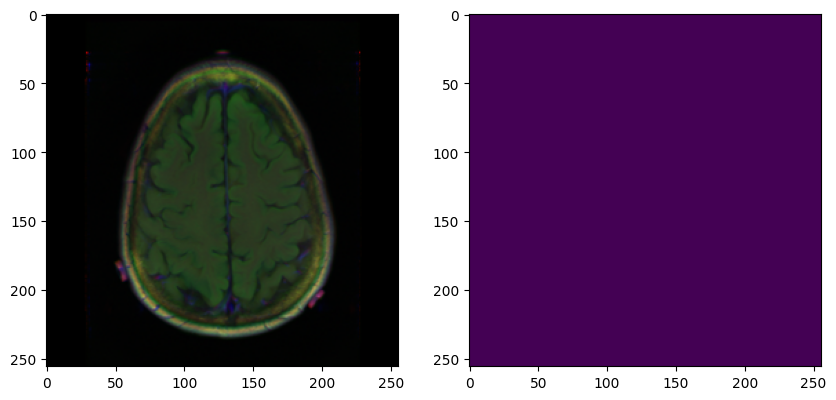

In [16]:
show_input_sample(f_images)

#Splitting images into mask/black-mask groups (done once to save them in files, if save_input_classes = True - before training)

In [17]:
if save_input_classes:
    f_images0 = []
    f_images1 = []

    for f in f_images:
        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(f)
            print(f[:-4] + '_mask.tif')
            data1 = archive.read(f[:-4] + '_mask.tif')

            mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            if mask.max() < 127:
                f_images0.append(f)
            else:
                f_images1.append(f)

    with open(DATA_PATH + "fN_im0.txt", "w") as fl:
        for f in f_images0:
            fl.write(f + '\n')

    with open(DATA_PATH + "fN_im1.txt", "w") as fl:
        for f in f_images1:
            fl.write(f + '\n')

#Read the previously saved input classes (from the text files generated in the code blocks above)

In [18]:
with open(DATA_PATH + "fN_im0.txt", "r") as fl:
    f_images0 = fl.readlines()

f_images0 = [f.strip() for f in f_images0]

with open(DATA_PATH + "fN_im1.txt", "r") as fl:
    f_images1 = fl.readlines()

f_images1 = [f.strip() for f in f_images1]

In [19]:
len(f_images0), len(f_images1)

(5112, 2746)

kaggle_3mN/TCGA_HT_7884_19980913/TCGA_HT_7884_19980913_8_mask.tif
255 0 [  0 255]


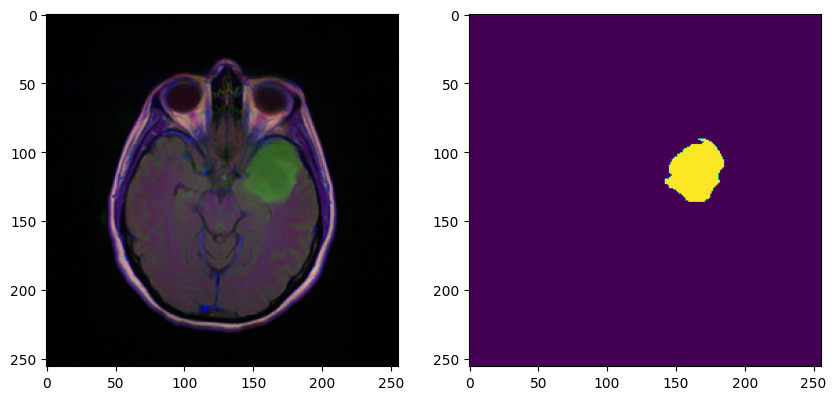

In [20]:
show_input_sample(f_images1)

kaggle_3mN/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_50+_mask.tif
0 0 [0]


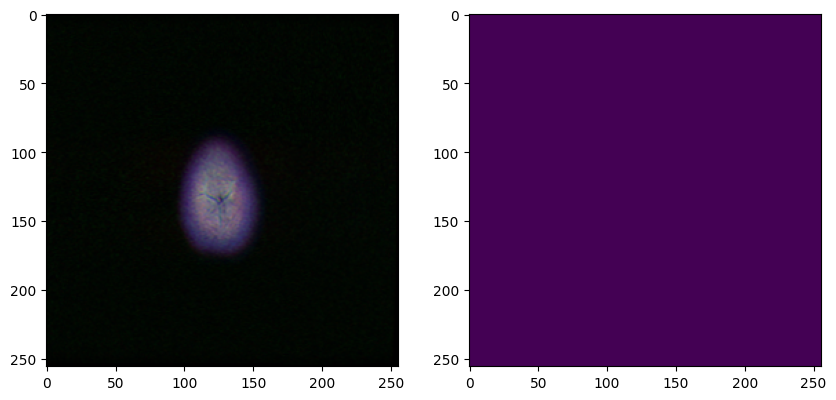

In [21]:
show_input_sample(f_images0)

#Splitting into training and test sets (done once to save them in files, if save_train_test_splitting = True - before training)

In [22]:
if save_train_test_splitting:
    random.shuffle(f_images0)
    train_len0 = int(0.9 * len(f_images0))
    df_train0 = f_images0[:train_len0]
    df_test0 = f_images0[train_len0:]

    random.shuffle(f_images1)
    train_len1 = int(0.9 * len(f_images1))
    df_train1 = f_images1[:train_len1]
    df_test1 = f_images1[train_len1:]

    #To make a balanced training dataset:

    diff = len(df_train0) - len(df_train1)
    random.shuffle(df_train1)
    df_train1.extend(df_train1[:diff])

    df_train = df_train0
    df_test = df_test0

    df_train.extend(df_train1)
    df_test.extend(df_test1)

    with open(DATA_PATH + 'dfN_train.txt', 'w') as fl:
        for f in df_train0:
            fl.write(f + '\n')

    with open(DATA_PATH + 'dfN_test.txt', 'w') as fl:
        for f in df_test0:
            fl.write(f + '\n')

#Read train/test data (lists of the file-names)

In [23]:
with open(DATA_PATH + 'dfN_train.txt', 'r') as fl:
    df_train = fl.readlines()
df_train = [f.strip() for f in df_train]

with open(DATA_PATH + 'dfN_test.txt', 'r') as fl:
    df_test = fl.readlines()
df_test = [f.strip() for f in df_test]

print(len(df_train))
print(len(df_test))

9200
787


In [24]:
# just to verify that the test data is not included in the training set
for dl in df_test:
    if dl in df_train:
        print('test line in the train set!!!')

#Swin transformer model loading

In [25]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k")
model_seg = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/915M [00:00<?, ?B/s]

#Generation batch with pictures-pairs: source image + mask image

In [26]:
class SegmentDataset(Dataset):
    def __init__(self,
                 gen_df,
                 transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((r_size, r_size)),
                 ]),
                 mask_color='GRAY'):
        self.gen_df = gen_df
        self.transform = transform
        self.mask_color = mask_color

    def __getitem__(self, index):
        img_name = self.gen_df[index]

        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(img_name)
            data1 = archive.read(img_name[:-4] + '_mask.tif')

        img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
        if self.mask_color == 'GRAY':
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        img_in = self.transform(img)
        mask = self.transform(mask)

        img = Image.fromarray(img)
        img = image_processor(images=img, return_tensors="pt")

        x = model_seg.embeddings(**img.to(device))
        input_dimensions=x[1]
        img0 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[0](x[0], input_dimensions=input_dimensions)
        img1 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[1](x[0], input_dimensions=(input_dimensions[0]//2, input_dimensions[1]//2) )
        img2 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[2](x[0], input_dimensions=(input_dimensions[0]//4, input_dimensions[1]//4) )
        img3 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[3](x[0], input_dimensions=(input_dimensions[0]//8, input_dimensions[1]//8) )
        x = model_seg.layernorm(x[0])
        img4 = x.detach().squeeze(0)

        return img0, img1, img2, img3, img4, mask, img_in

    def __len__(self):
        return len(self.gen_df)

#Example with batch generation:

In [27]:
try_dataset = SegmentDataset(df_train, mask_color='RGB')

try_dataloader = DataLoader(try_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(try_dataloader)

torch.Size([8, 2304, 192]) torch.Size([8, 576, 384]) torch.Size([8, 144, 768]) torch.Size([8, 36, 1536]) torch.Size([8, 36, 1536])
torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])


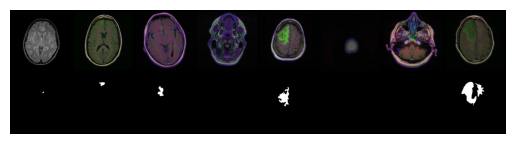

In [28]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter)
print(i0.shape, i1.shape, i2.shape, i3.shape, i4.shape)
print(y.shape, x1.shape)

concatenated = torch.cat((x1, y),0)
c_img = torchvision.utils.make_grid(concatenated).permute(1, 2, 0)
plt.axis("off")
plt.imshow(c_img)

In [29]:
del try_dataloader
del try_dataset
del concatenated
del c_img

#Trying transfer learning based on ViT

In [30]:
train_dataset = SegmentDataset(df_train, mask_color='GRAY')

###Network creation (model, loss function, optimizer)

In [31]:
class Up_Linear(nn.Module):
    def __init__(self, in_ch, size, coef=1):
        super(Up_Linear, self).__init__()
        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        n_ch = int(coef * in_ch)

        self.ln = nn.Sequential(
            nn.Linear(in_ch * 2, n_ch),
            nn.ReLU(inplace=True),
            nn.Linear(n_ch, in_ch * 2),
            nn.ReLU(inplace=True),
        )

        self.size = size

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), 2)
        x = self.ln(x)
        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size, self.size))
        x = self.shuffle(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size*self.size*4))
        x = x.permute(0, 2, 1)
        return x

class MRI_Seg(nn.Module):
    def __init__(self):
        super(MRI_Seg, self).__init__()

        self.ups3 = Up_Linear(1536, 6, 1)
        self.ups2 = Up_Linear(768, 12, 1)
        self.ups1 = Up_Linear(384, 24, 2)
        self.ups0 = Up_Linear(192, 48, 3)

        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        self.out = nn.Sequential(
            nn.Conv2d(24, 1, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x0, x1, x2, x3, x4):
        x = self.ups3(x4, x3)
        x = self.ups2(x, x2)
        x = self.ups1(x, x1)
        x = self.ups0(x, x0)

        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], 96, 96))
        x = self.shuffle(x)
        x = transforms.Resize((256, 256))(x)

        x = self.out(x)
        return x


In [32]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size)

net = MRI_Seg().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [33]:
len(train_dataloader)

575

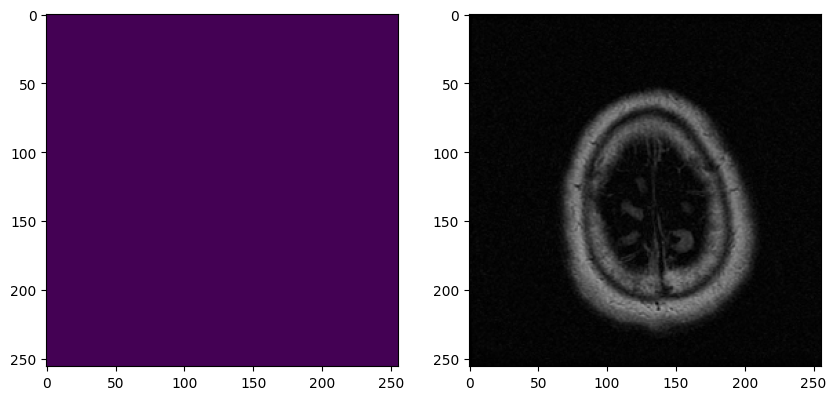

In [34]:
dataiter = iter(train_dataloader)
i0, i1, i2, i3, i4, y, x1 = next(dataiter)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].imshow(y[0].permute(1, 2, 0))
axes[1].imshow(x1[0].permute(1, 2, 0))
plt.show()

In [35]:
summary(model=net, input_size=[(1, 2304, 192), (1, 576, 384), (1, 144, 768), (1, 36, 1536), (1, 36, 1536)], col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
MRI_Seg                                  [1, 2304, 192]            [1, 1, 256, 256]          --                        True
├─Up_Linear: 1-1                         [1, 36, 1536]             [1, 144, 768]             --                        True
│    └─Sequential: 2-1                   [1, 36, 3072]             [1, 36, 3072]             --                        True
│    │    └─Linear: 3-1                  [1, 36, 3072]             [1, 36, 1536]             4,720,128                 True
│    │    └─ReLU: 3-2                    [1, 36, 1536]             [1, 36, 1536]             --                        --
│    │    └─Linear: 3-3                  [1, 36, 1536]             [1, 36, 3072]             4,721,664                 True
│    │    └─ReLU: 3-4                    [1, 36, 3072]             [1, 36, 3072]             --                        --
│    └─

###Non-trained network output

In [36]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

torch.Size([16, 1, 256, 256]) torch.Size([1, 256, 256])
tensor(0.)
tensor(0.7731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


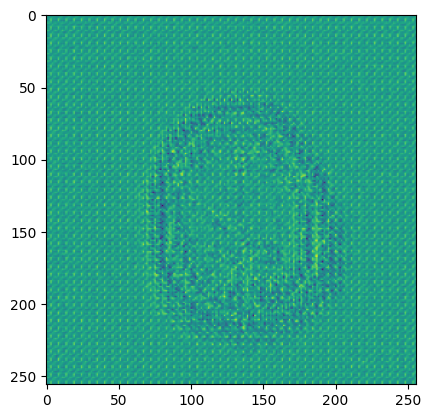

In [37]:
out = net(Variable(i0).to(device), Variable(i1).to(device), Variable(i2).to(device), Variable(i3).to(device), Variable(i4).to(device))
print(out.shape, y[0].shape)
print(y[0].max())

ls = criterion(out[0], Variable(y[0]).to(device))

print(ls)
plt.imshow(out[0].cpu().detach().numpy()[0])
del out

###Training pipeline

In [38]:
def train_net():
    num_iter = len(train_dataloader)
    ep_init = 0

    for epoch in range(ep_init, ep_num):
        sum_loss = 0
        print("Epoch number: {}".format(epoch))
        for i, data in enumerate(train_dataloader, 0):

            img0, img1, img2, img3, img4, mask, img_in = data

            optimizer.zero_grad()

            x0 = Variable(img0).to(device)
            x1 = Variable(img1).to(device)
            x2 = Variable(img2).to(device)
            x3 = Variable(img3).to(device)
            x4 = Variable(img4).to(device)

            output = net(x0, x1, x2, x3, x4)
            # label.squeeze() - to transform lables to 1-dim vector
            # without squeeze() loss calculation is incorrect
            loss_bce = criterion(output, Variable(mask).to(device))
            loss_bce.backward()
            optimizer.step()

            sum_loss += loss_bce.data
            if i % 10 == 0:
                print('{} ===================  {}'.format(i, sum_loss/(i + 1)))

        print("Epoch number: {}, Num iter: {}, lr: {}, Current loss: {}".format(epoch, num_iter, optimizer.param_groups[0]['lr'], sum_loss/num_iter))
        torch.save(net, FILE_NAME + '_{}'.format(epoch + 1))

    torch.save(net, FILE_NAME)
    print("The pre-trained model saved")

In [39]:
if use_pre_trained is False:
    net.train().to(device)
    train_net()

#Testing

###Showing detection results with mask and rectangle: utility functions

In [40]:
def calc_rect(img_mask):
    ind = np.argwhere(img_mask >= 0.5)
    if len(ind) == 0:
        return None, None
    top_y = min(ind[:,0])
    bottom_y = max(ind[:,0])
    top_x = min(ind[:,1])
    bottom_x = max(ind[:,1])
    return (top_x, top_y), (bottom_x, bottom_y)

def show_results(i0, i1, i2, i3, i4, y, x1, im_id):
    ii0 = Variable(i0).to(device)
    ii1 = Variable(i1).to(device)
    ii2 = Variable(i2).to(device)
    ii3 = Variable(i3).to(device)
    ii4 = Variable(i4).to(device)
    pred = net(ii0, ii1, ii2, ii3, ii4)
    pr = pred[im_id].cpu().detach().numpy()[0]

    xim = copy.deepcopy(x1[im_id].permute(1, 2, 0).cpu().detach().numpy())
    # just to transform numpy array to cv2 image:
    xim = cv2.resize(xim, (r_size, r_size))
    top_left, bottom_right = calc_rect(pr)
    if top_left is not None:
        cv2.rectangle(xim, top_left, bottom_right, (255, 0, 0), 2)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(y[im_id].cpu().detach().numpy()[0])
    axes[1].imshow(pr > 0.5)
    axes[2].imshow(xim)

    plt.show()

In [41]:
if use_pre_trained:
    del net
    net = torch.load(FILE_NAME_PR)
    print("The pre-trained model loaded")

The pre-trained model loaded


In [42]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

###Reference mask, predicted mask, detected rectangle area

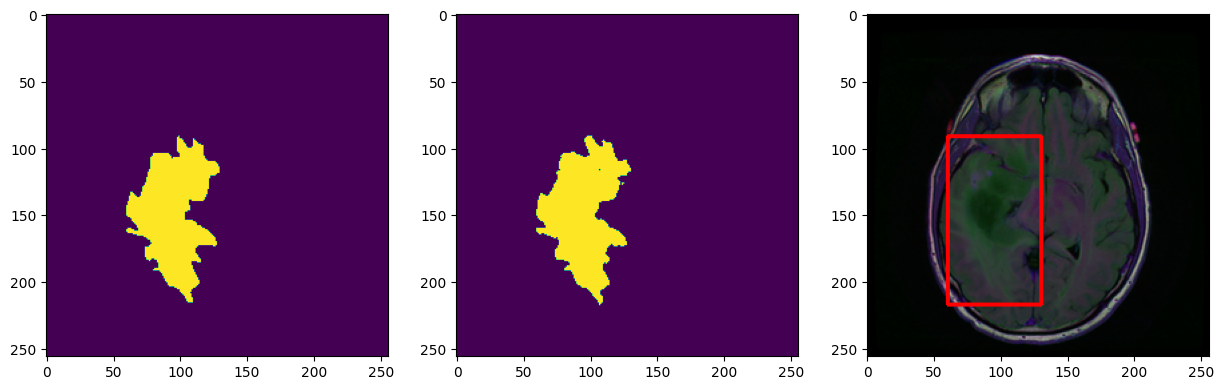

In [43]:
show_results(i0, i1, i2, i3, i4, y, x1, 2)

###Accuracy (IoU) calculation:

###Data loaders for IoU calculation data (both training and test sets):

In [44]:
test_dataloader1 = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)

test_dataset = SegmentDataset(df_test)
test_dataloader2 = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

In [45]:
dataiter = iter(test_dataloader1)

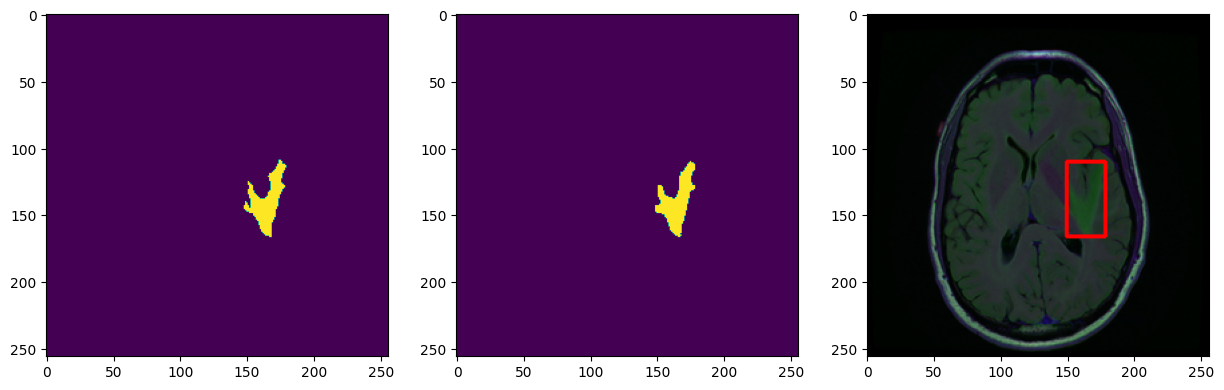

In [46]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter)
show_results(i0, i1, i2, i3, i4, y, x1, 0)

###IoU calculation function

In [47]:
def calc_accuracy(test_dataloader, set_id, model, sample_num=None):
    batch_size = 1
    if not sample_num:
        N = len(test_dataloader)
    else:
        if sample_num <= 0:
            sample_num = len(test_dataloader)
        N = min(sample_num, len(test_dataloader))

    And = 0
    Uni = 0
    Uni_dice = 0

    T0 = 0
    T1 = 0
    F0 = 0
    F1 = 0

    for i, data in enumerate(test_dataloader, 0):
        #xx, yy, xs = data
        img0, img1, img2, img3, img4, yy, xs = data

        x0 = Variable(img0).to(device)
        x1 = Variable(img1).to(device)
        x2 = Variable(img2).to(device)
        x3 = Variable(img3).to(device)
        x4 = Variable(img4).to(device)

        xx1 = model(x0, x1, x2, x3, x4)
        xx1 = xx1[0][0].cpu().detach().numpy()
        yy = yy[0][0].cpu().detach().numpy()
        xx1[xx1 >= 0.5 ] = 1
        xx1[xx1 < 0.5 ] = 0

        owl = np.sum(xx1*yy)
        And += owl
        a_uni_dice = np.sum(xx1 + yy)
        a_uni = a_uni_dice - owl
        Uni += a_uni
        Uni_dice += a_uni_dice

        if xx1.max() == 0 and yy.max() == 0:
            T0 += 1
        if xx1.max() == 1 and yy.max() == 1:
            T1 += 1
        if xx1.max() == 0 and yy.max() == 1:
            F0 += 1
        if xx1.max() == 1 and yy.max() == 0:
            F1 += 1

        print('{}:  i = {}, And = {}, Uni = {}'.format(set_id, i, And, Uni))

        if i >= N - 1:
            break

    IoU_av = And / Uni
    Dice = 2*And / Uni_dice

    return  IoU_av, Dice, T0, T1, F0, F1


###IoU calculation on the training set

In [48]:
IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr = calc_accuracy(test_dataloader1, 'train', net, sample_num=550)

train:  i = 0, And = 0.0, Uni = 0.0
train:  i = 1, And = 1446.0, Uni = 1527.0
train:  i = 2, And = 1446.0, Uni = 1527.0
train:  i = 3, And = 2376.0, Uni = 2526.0
train:  i = 4, And = 2376.0, Uni = 2526.0
train:  i = 5, And = 2376.0, Uni = 2526.0
train:  i = 6, And = 2376.0, Uni = 2526.0
train:  i = 7, And = 7155.0, Uni = 7420.0
train:  i = 8, And = 11410.0, Uni = 11875.0
train:  i = 9, And = 11410.0, Uni = 11875.0
train:  i = 10, And = 11410.0, Uni = 11875.0
train:  i = 11, And = 11410.0, Uni = 11875.0
train:  i = 12, And = 12775.0, Uni = 13294.0
train:  i = 13, And = 12775.0, Uni = 13294.0
train:  i = 14, And = 17046.0, Uni = 17767.0
train:  i = 15, And = 18082.0, Uni = 18940.0
train:  i = 16, And = 18082.0, Uni = 18940.0
train:  i = 17, And = 18082.0, Uni = 18940.0
train:  i = 18, And = 21739.0, Uni = 22730.0
train:  i = 19, And = 23425.0, Uni = 24595.0
train:  i = 20, And = 27050.0, Uni = 28344.0
train:  i = 21, And = 29550.0, Uni = 31020.0
train:  i = 22, And = 30196.0, Uni = 31760

In [49]:
print('training set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr))

training set: IoU = 0.9473354929041328, Dice = 0.972955606628765, True_0 = 257, True_1 = 286, False_0 = 1, False_1 = 6


###IoU calculation on the test set

In [50]:
IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts = calc_accuracy(test_dataloader2, 'test', net)

test:  i = 0, And = 0.0, Uni = 0.0
test:  i = 1, And = 0.0, Uni = 0.0
test:  i = 2, And = 0.0, Uni = 0.0
test:  i = 3, And = 0.0, Uni = 34.0
test:  i = 4, And = 0.0, Uni = 34.0
test:  i = 5, And = 0.0, Uni = 34.0
test:  i = 6, And = 0.0, Uni = 34.0
test:  i = 7, And = 0.0, Uni = 34.0
test:  i = 8, And = 0.0, Uni = 34.0
test:  i = 9, And = 0.0, Uni = 34.0
test:  i = 10, And = 0.0, Uni = 34.0
test:  i = 11, And = 0.0, Uni = 34.0
test:  i = 12, And = 0.0, Uni = 34.0
test:  i = 13, And = 0.0, Uni = 34.0
test:  i = 14, And = 0.0, Uni = 34.0
test:  i = 15, And = 0.0, Uni = 34.0
test:  i = 16, And = 0.0, Uni = 34.0
test:  i = 17, And = 0.0, Uni = 34.0
test:  i = 18, And = 0.0, Uni = 43.0
test:  i = 19, And = 0.0, Uni = 43.0
test:  i = 20, And = 0.0, Uni = 43.0
test:  i = 21, And = 0.0, Uni = 43.0
test:  i = 22, And = 0.0, Uni = 43.0
test:  i = 23, And = 0.0, Uni = 43.0
test:  i = 24, And = 0.0, Uni = 43.0
test:  i = 25, And = 0.0, Uni = 43.0
test:  i = 26, And = 0.0, Uni = 43.0
test:  i = 27,

In [51]:
print('test set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts))

test set: IoU = 0.8444909446712451, Dice = 0.9156899871056443, True_0 = 470, True_1 = 273, False_0 = 2, False_1 = 42
